In [210]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
#Import the dataset
deliveries_df = pd.read_csv("C:/Users/princ/Downloads/deliveries.csv")
matches_df = pd.read_csv("C:/Users/princ/Downloads/matches.csv")

In [212]:
deliveries_df.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed'],
      dtype='object')

In [213]:
#filling na values for all float datatypes
deliveries_df[["wides", "noballs", "byes", "legbyes", "penalty"]] = deliveries_df[["wides", "noballs", "byes", "legbyes", "penalty"]].fillna(0)

In [214]:
#print(deliveries_df.describe())
#print(deliveries_df.dtypes)

In [215]:
#Changing the datatype to Integer 
deliveries_df['penalty'] = deliveries_df['penalty'].astype(np.int64)

In [216]:
print(deliveries_df['penalty'].unique())
print(deliveries_df['wicket_type'].unique())
#print(deliveries_df['player_dismissed'].unique())
print(deliveries_df['other_wicket_type'].unique())
print(deliveries_df['other_player_dismissed'].unique())

[0 5]
[nan 'caught' 'bowled' 'caught and bowled' 'lbw' 'run out' 'stumped'
 'retired hurt']
[nan 'timed out']
[nan 'AD Mathews']


In [217]:
#Removing columns
deliveries_df = deliveries_df.drop(['other_player_dismissed', 'other_wicket_type'], axis =1)

In [218]:
deliveries_df.wicket_type.fillna("No Wicket", inplace = True)
deliveries_df.player_dismissed.fillna("No Wicket", inplace = True)

In [219]:
#print(deliveries_df.isnull().sum())
#print(matches_df.isnull().sum())

In [220]:
unique_counts = deliveries_df['player_dismissed'].value_counts()
#filtered_counts = unique_counts[unique_counts > 8]
#print(filtered_counts)

In [221]:
#Creating wicket column for each delivery, 1 if its a wicket or 0 for non dismissal
deliveries_df['wicket'] = deliveries_df['player_dismissed'].apply(lambda x: 0 if x == "No Wicket" else 1)

In [222]:
#deliveries_df.isnull().sum()
#matches_df.isna().sum()

In [223]:
matches_df.rename(columns={"winner_runs":"win_by_runs", "winner_wickets":"win_by_wickets"}, inplace=True)

In [224]:
matches_df.win_by_runs.fillna(0, inplace = True)
matches_df.win_by_wickets.fillna(0, inplace = True)

In [225]:
matches_df = matches_df.drop(["reserve_umpire"],axis =1)

In [226]:
#Lets create overs, ball number and balls left columns
deliveries_df["ball"] = deliveries_df["ball"].astype(str)
deliveries_df[["over","ball_number"]] = deliveries_df["ball"].str.split(".",expand = True).astype(int)

In [227]:
deliveries_df["over"] = deliveries_df["over"]+1

In [228]:
deliveries_df["balls_left"] = 306 - (deliveries_df["over"] * 6 + deliveries_df["ball_number"])

In [229]:
#Create total run per ball
#creating total runs column to calculate runs on each ball incusive of extras
deliveries_df["total_runs_per_ball"] = deliveries_df["runs_off_bat"] + deliveries_df["extras"]

In [230]:
#Create cumulative_runs columns to calculate cumulative runs based on Innings 
deliveries_df["cum_runs"] = deliveries_df.groupby(["match_id", "innings"])["total_runs_per_ball"].cumsum()

In [231]:
#Lets calculate run_rate column for each ball
deliveries_df["run_rate"] = deliveries_df.groupby(["match_id",
                                                   "innings"]).apply(lambda x:(x["cum_runs"]*6)/(300-x["balls_left"])).reset_index(level=[0,1], 
                                                                                                                                         drop=True)

In [232]:
#Split the dataframe into first innings and second innings to calculate target and required run rate(rrr)
first_innings_df = deliveries_df[deliveries_df["innings"] == 1]
first_innings = first_innings_df.groupby("match_id")["cum_runs"].max().reset_index()
first_innings.rename(columns={"cum_runs": "target"}, inplace=True)

In [233]:
second_innings_df = deliveries_df[deliveries_df["innings"] == 2]
second_innings_df = second_innings_df.merge(first_innings, on="match_id", how="left")
second_innings_df["target"] = second_innings_df["target"]+1

In [234]:
#Calculate runs needed and rrr for second innings dataframe
second_innings_df["runs_needed"] = second_innings_df["target"] - second_innings_df["cum_runs"]
second_innings_df["required_run_rate"] = (second_innings_df["runs_needed"]*6) / second_innings_df["balls_left"]
#second_innings.head(10)

In [235]:
second_innings_df.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'wicket', 'over',
       'ball_number', 'balls_left', 'total_runs_per_ball', 'cum_runs',
       'run_rate', 'target', 'runs_needed', 'required_run_rate'],
      dtype='object')

In [236]:
#Combine both datasets to creata a final cleaned dataframe
full_innings_df = pd.concat([first_innings_df,second_innings_df])

In [237]:
full_innings_df.fillna(0,inplace = True)

In [238]:
matches_df.rename(columns = {"match_number":"match_id", "start_date":"date"},inplace = True)

In [239]:
#Merge matches data with innings to get the winner, win_by_runs and win_by_wickets data
full_innings_df = full_innings_df.merge(matches_df[["match_id","winner", "win_by_runs", "win_by_wickets","match_type","toss_winner","toss_decision"]], on = "match_id")

In [240]:
#Define result of the match
full_innings_df["result"] = full_innings_df.apply(lambda x: 1 if x["batting_team"] == x["winner"] else 0, axis=1)

In [241]:
pd.set_option('display.max_columns', None)

# Cleaned and Analyzed DataFrame: 'full_innings_df'

In [242]:
full_innings_df.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'wicket', 'over',
       'ball_number', 'balls_left', 'total_runs_per_ball', 'cum_runs',
       'run_rate', 'target', 'runs_needed', 'required_run_rate', 'winner',
       'win_by_runs', 'win_by_wickets', 'match_type', 'toss_winner',
       'toss_decision', 'result'],
      dtype='object')

# Highest Individual Runs Scored by a Batshmen in the world cup

In [243]:
total_runs_by_batsman = full_innings_df.groupby(['match_id', 'striker', 'batting_team', 'bowling_team'])['total_runs_per_ball'].sum().reset_index()
highest_scorer = total_runs_by_batsman.loc[total_runs_by_batsman['total_runs_per_ball'].idxmax()]

print("Batsman with the Highest Individual Runs in a Match:",
      highest_scorer['total_runs_per_ball'],
      "by",
      highest_scorer['striker'],
      "against",
      highest_scorer['bowling_team'])

Batsman with the Highest Individual Runs in a Match: 207 by GJ Maxwell against Afghanistan


# Which team successfully chased the highest target in the ICC ODI World Cup 2023, and who were they playing against?

In [244]:
successfull_chases = full_innings_df[full_innings_df["result"] == 1]
highest_successful_target = successfull_chases['target'].max()
match_with_highest_target = successfull_chases[successfull_chases['target'] == highest_successful_target].iloc[0]
print("Highest Target Chased Successfully in ICC ODI World Cup 2023:", 
      highest_successful_target,
      "by",
      match_with_highest_target['batting_team'],
      "against",
      match_with_highest_target['bowling_team'])

Highest Target Chased Successfully in ICC ODI World Cup 2023: 402.0 by Pakistan against New Zealand


# Most runs scored by both the teams combined in a match

In [245]:
runs_scored_per_match = full_innings_df.groupby('match_id')['total_runs_per_ball'].sum().reset_index()
most_runs_scored = runs_scored_per_match.loc[runs_scored_per_match['total_runs_per_ball'].idxmax()]

most_runs_scored_by_team = full_innings_df[full_innings_df['match_id']== most_runs_scored['match_id']][['batting_team', 'bowling_team']].drop_duplicates().iloc[0]

print("Match with most runs scored:",most_runs_scored['total_runs_per_ball'],"by",most_runs_scored_by_team['batting_team'],"and",most_runs_scored_by_team['bowling_team'])

Match with most runs scored: 771 by Australia and New Zealand


# Timeline of runs scored by each team in a match

In [246]:
final_match_df_final = full_innings_df[full_innings_df['match_id'] == 27]
final_match_df_final = final_match_df_final[["match_id","innings","ball","batting_team","bowling_team","runs_off_bat",
                                            "over","total_runs_per_ball","cum_runs","run_rate","wicket",
                                             'target']]

In [247]:
final_match_df_final['runs_scored'] = final_match_df_final.groupby(['innings'])['total_runs_per_ball'].cumsum()
final_match_df_final['overs_interval'] = final_match_df_final['over'].apply(lambda x: x if x % 5 == 0 else 0)
final_match_df_final = final_match_df_final[["innings", "overs_interval",'runs_scored']]
final_match_df_final = final_match_df_final.rename(columns= {'innings':"Team"})
final_match_df_final["Team"] = final_match_df_final["Team"].apply(lambda x: "Australia" if x ==1 else "New Zealand")

#selected_columns = ["innings", "overs_interval", 'runs_scored']
filtered_df = final_match_df_final[final_match_df_final['overs_interval'] % 5 == 0]
filtered_df['runs_scored'] = filtered_df.apply(lambda row: 0 if row['overs_interval'] == 0 else row['runs_scored'], axis=1)

#Table with runs scored for a 5 over interval for both the innings
filtered_df = filtered_df[["Team", "overs_interval", 'runs_scored']].groupby(['Team', 'overs_interval']).max().reset_index()

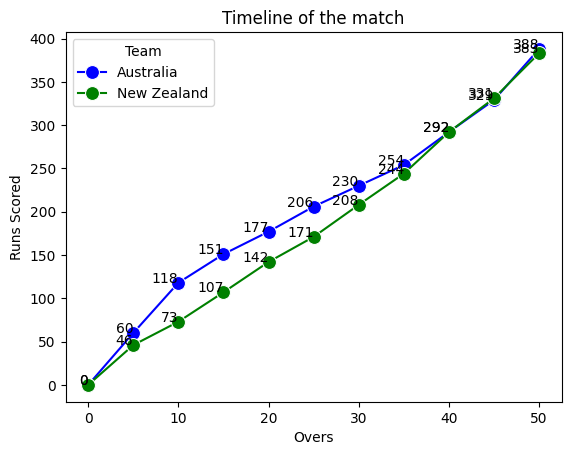

In [248]:
colors = {'Australia': 'blue', 'New Zealand': 'green'}
# Create a line plot
lineplot = sns.lineplot(data=filtered_df, 
             x='overs_interval', 
             y='runs_scored', 
             hue='Team',
             palette=colors,
             marker='o',
             markersize = 10)

# Set plot labels and title
plt.xlabel('Overs')
plt.ylabel('Runs Scored')
plt.title('Timeline of the match')
plt.legend(title='Team', loc='upper left')
plt.xticks(range(0, filtered_df['overs_interval'].max() + 1, 10))
for line in range(0,filtered_df.shape[0]):
     lineplot.text(filtered_df["overs_interval"].iloc[line], 
             filtered_df["runs_scored"].iloc[line], 
             filtered_df["runs_scored"].iloc[line], 
             horizontalalignment='right', size='medium', color='black')
plt.show()

# Top 10 Highest Run-Scorers Batsmen List

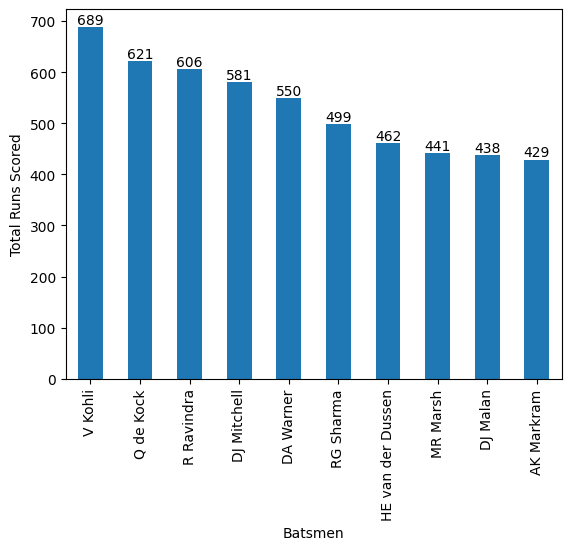

In [249]:
batsmen_runs = full_innings_df.groupby("striker")["total_runs_per_ball"].sum().reset_index()
top_10_batsmen_runs = batsmen_runs.nlargest(10, "total_runs_per_ball")
bargraph = top_10_batsmen_runs.plot(kind="bar", 
                         stacked=True, 
                         x= "striker", 
                         y= "total_runs_per_ball",
                         legend = False)
plt.xlabel("Batsmen")
plt.ylabel("Total Runs Scored")
for index, value in enumerate(top_10_batsmen_runs['total_runs_per_ball']):
    bargraph.text(index, value, str(value), ha='center', va='bottom')
plt.show()

# Top 10 most wickets taken bowler list

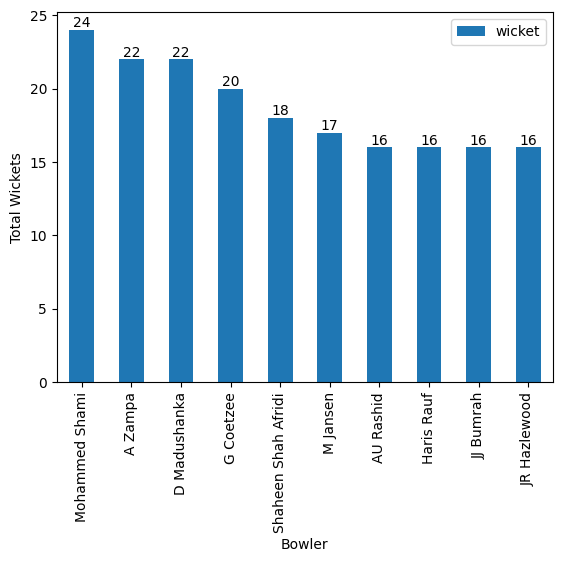

In [250]:
bowler_wickets = full_innings_df.groupby("bowler")["wicket"].sum().reset_index()
top_10_bowlers_wicekts = bowler_wickets.nlargest(10, "wicket")
bargraph2 = top_10_bowlers_wicekts.plot(kind="bar", stacked=True, x= "bowler", y= "wicket")
plt.xlabel("Bowler")
plt.ylabel("Total Wickets")
for index, value in enumerate(top_10_bowlers_wicekts['wicket']):
    bargraph2.text(index, value, str(value), ha='center', va='bottom')
plt.show()

# Win Percentage of each team

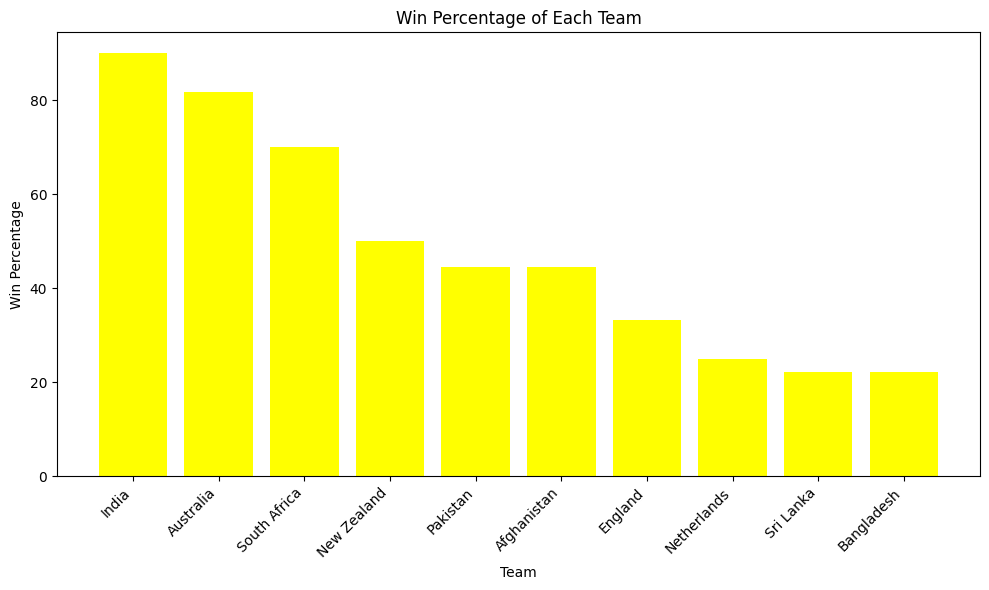

In [258]:
#Matches won by each team
matches_won = matches_df.groupby('winner').size().reset_index(name = 'matches_won')
matches_won = matches_won.rename(columns = {'winner':'team'})

#Matches played by each team
team1_names = pd.Series(matches_df['team1'].unique())
team2_names = pd.Series(matches_df['team2'].unique())
unique_teams = pd.unique(pd.concat([team1_names, team2_names], ignore_index=True))

#DataFrame with the total number of matches played by each team
matches_played = pd.DataFrame(index=unique_teams, columns=['total_matches'])
matches_played.index.name = 'team'

for team in unique_teams:
    team_matches = matches_df[(matches_df['team1'] == team) | (matches_df['team2'] == team)]
    matches_played.loc[team, 'total_matches_played'] = len(team_matches)

#Merge the two DataFrames on the 'team' column
win_percentage_df = pd.merge(matches_played, matches_won, on='team', how='left').fillna(0)
win_percentage_df['matches_won'] = win_percentage_df['matches_won'].astype(float)

# Calculate the win percentage for each team
pd.set_option('display.float_format', '{:.2f}'.format)
win_percentage_df['win_percentage'] = (win_percentage_df['matches_won'] / win_percentage_df['total_matches_played']) * 100
# Sort the DataFrame by win percentage in descending order
win_percentage_df = win_percentage_df.sort_values(by='win_percentage', ascending=False)

# Plot the win percentage graph
plt.figure(figsize=(10, 6))
plt.bar(win_percentage_df['team'], win_percentage_df['win_percentage'], color='yellow')
plt.xlabel('Team')
plt.ylabel('Win Percentage')
plt.title('Win Percentage of Each Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Wicket Distribution Across Every Over

In [252]:
wickets_distribution_df = full_innings_df[["match_id","innings","ball","batting_team","bowling_team",
                                            "over","wicket","wicket_type"]]
wickets_distribution_df['wickets_taken'] = wickets_distribution_df.groupby(['over'])['wicket'].cumsum()
wickets_distribution_df = wickets_distribution_df[["over",'wickets_taken']].groupby('over').max().reset_index()

C:\Users\princ\AppData\Local\Temp\ipykernel_4084\3049315516.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wickets_distribution_df['wickets_taken'] = wickets_distribution_df.groupby(['over'])['wicket'].cumsum()


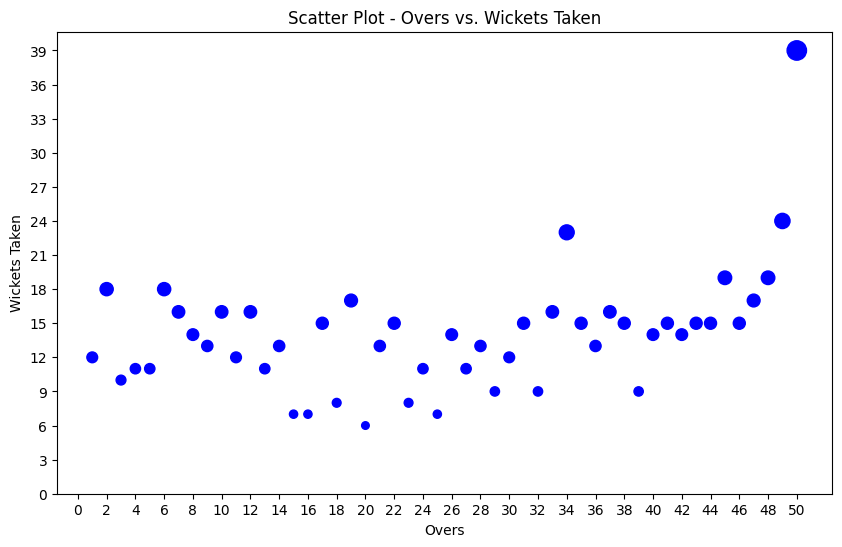

In [253]:
#Wicket distribution across every over Scatter plot 
plt.figure(figsize=(10, 6))
plt.scatter(
    wickets_distribution_df['over'],
    wickets_distribution_df['wickets_taken'],
    s=wickets_distribution_df['wickets_taken'] * 5,
    color='blue',
    marker='o'
)
plt.xlabel('Overs')
plt.ylabel('Wickets Taken')
plt.title('Scatter Plot - Overs vs. Wickets Taken')
plt.xticks(range(0, max(wickets_distribution_df['over']) + 1, 2))
plt.yticks(range(0, max(wickets_distribution_df['wickets_taken']) + 3, 3))
# Show the scatter plot
plt.show()


# Proportion of Extras to Total Runs: Team-wise Analysis

In [270]:
Extras_df = full_innings_df[['match_id','innings','batting_team','bowling_team','runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty','wicket_type','player_dismissed','total_runs_per_ball', 'cum_runs']]
Extras_df["cum_extras_given"] = Extras_df.groupby(['match_id', 'innings',"bowling_team"])['extras'].cumsum()

C:\Users\princ\AppData\Local\Temp\ipykernel_4084\419065214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Extras_df["cum_extras_given"] = Extras_df.groupby(['match_id', 'innings',"bowling_team"])['extras'].cumsum()


In [271]:
extra_given = Extras_df.groupby(['match_id', 'innings',"bowling_team"])["cum_extras_given"].max().reset_index()
cum_sum = Extras_df.groupby(['match_id', 'innings',"bowling_team"])["cum_runs"].max().reset_index()

In [274]:
df = pd.merge(extra_given, cum_sum, on= ["match_id","innings","bowling_team"])
df['percentage_of_extras'] = (df['cum_extras_given'] / df['cum_runs']) * 100
df = df.rename(columns={'bowling_team': 'team'})
#average_extras_per_match = df.groupby('team')['cum_extras_given'].mean().reset_index()

,match_id,innings,team,cum_extras_given,cum_runs,percentage_of_extras
0,1,1,New Zealand,6,282,2.13
1,1,2,England,8,283,2.83
2,2,1,Netherlands,9,286,3.15
3,2,2,Pakistan,9,205,4.39
4,3,1,Bangladesh,8,156,5.13
...,...,...,...,...,...,...
87,44,2,England,6,244,2.46
88,46,1,New Zealand,8,397,2.02
89,46,2,India,29,327,8.87
90,47,1,Australia,11,212,5.19


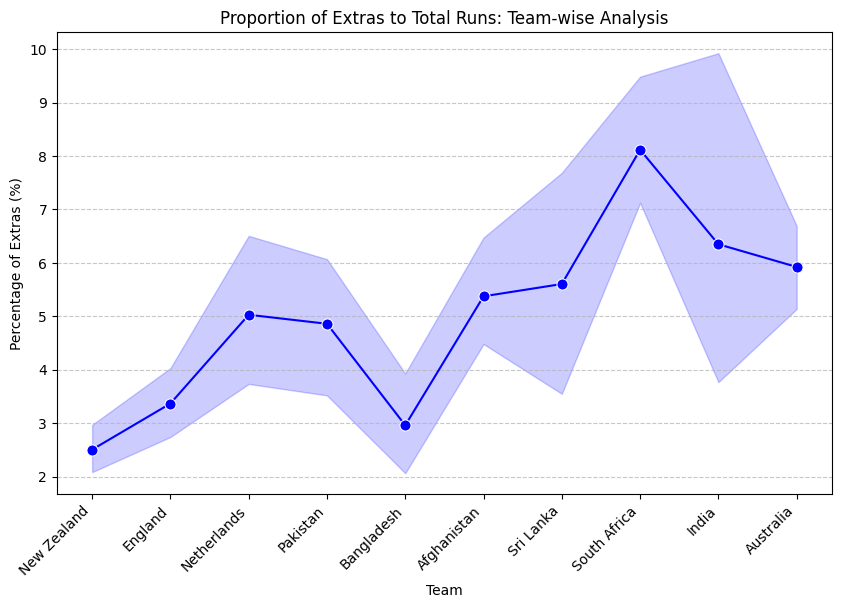

In [278]:
# Plotting a bar plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='team', y='percentage_of_extras', data=df, marker='o', markersize=8, color='blue')
plt.title('Proportion of Extras to Total Runs: Team-wise Analysis')
plt.xlabel('Team')
plt.ylabel('Percentage of Extras (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
plt.show()

# Thank you,  If you have any questions or suggestions, don't hesitate to reach out. Happy exploring! 🏏📊